In [57]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [18, 9] #figure size
plt.rcParams.update({'font.size': 22}) # caption size

In [58]:
def get_ts_vals(limit):
    ts_vals = []
    ts_vals.append(1.5)
    for i in range(1, limit+1):
        if i < 26:
            next_val = ts_vals[i-1] - 0.1 * ts_vals[i-1]
        else:
            next_val = ts_vals[i-1] + 0.2 * ts_vals[i-26]/(1.0 + ts_vals[i-26]**10) - 0.1 * ts_vals[i-1]
        ts_vals.append(next_val)
    return ts_vals

In [59]:
ts_vals = np.array(get_ts_vals(1505))
input = [ts_vals[(idx-20):(idx+1):5] for idx in range(301, 1501)]
input = np.vstack(input)
output = ts_vals[306:]
output = output.reshape(len(output), 1)
input.shape, output.shape

((1200, 5), (1200, 1))

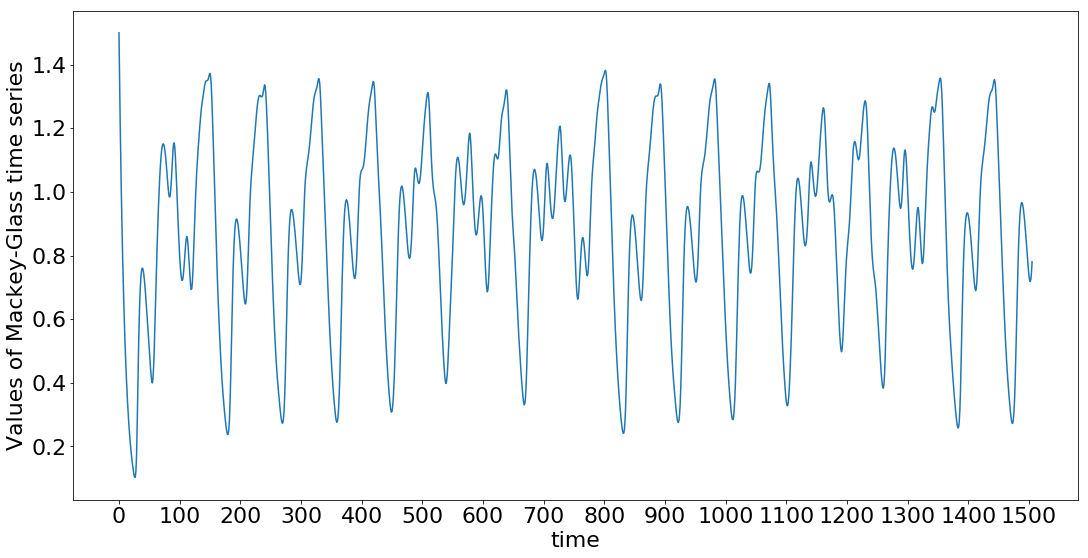

In [60]:
fig, ax = plt.subplots()
ax.set_xlabel('time')
ax.set_ylabel('Values of Mackey-Glass time series')

plt.xticks(np.arange(0, len(ts_vals), 100))
plt.plot(range(0, len(ts_vals)), ts_vals)
plt.show()

In [61]:
train_inputs = input[:-200]
train_targets = output[:-200]
shuffled_index = np.random.permutation(train_inputs.shape[0])
train_inputs = train_inputs[shuffled_index]
train_targets = train_targets[shuffled_index]

test_inputs = input[-200:]
test_targets = output[-200:]

# 3 nodes, big lambda for weight decay

In [62]:
#2 layer network
def build_model():
    l1 = layers.Dense(3, activation=tf.sigmoid, input_shape=[5], 
                     kernel_regularizer=keras.regularizers.l2(10.0))
    model = keras.Sequential([
        #here the first number is the number of nodes in the first layer
        l1, 
        #same for the second layer
        #layers.Dense(2, activation=tf.sigmoid),
        #output shape is 1
        layers.Dense(1)
    ])
    
    #can change learning rate here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)

    #mse is the chosen metric
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model, l1

In [63]:
model, l1 = build_model()

#comments a dot after every finished epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

#if patience number of epochs pass without showing improvement on the validation set, then 
#it will stop. If you want to test the network without it, remove it from callbacks attribute of the 
#next call
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  train_inputs, train_targets,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, #can set validation split here
  callbacks=[ PrintDot()])


..................................................

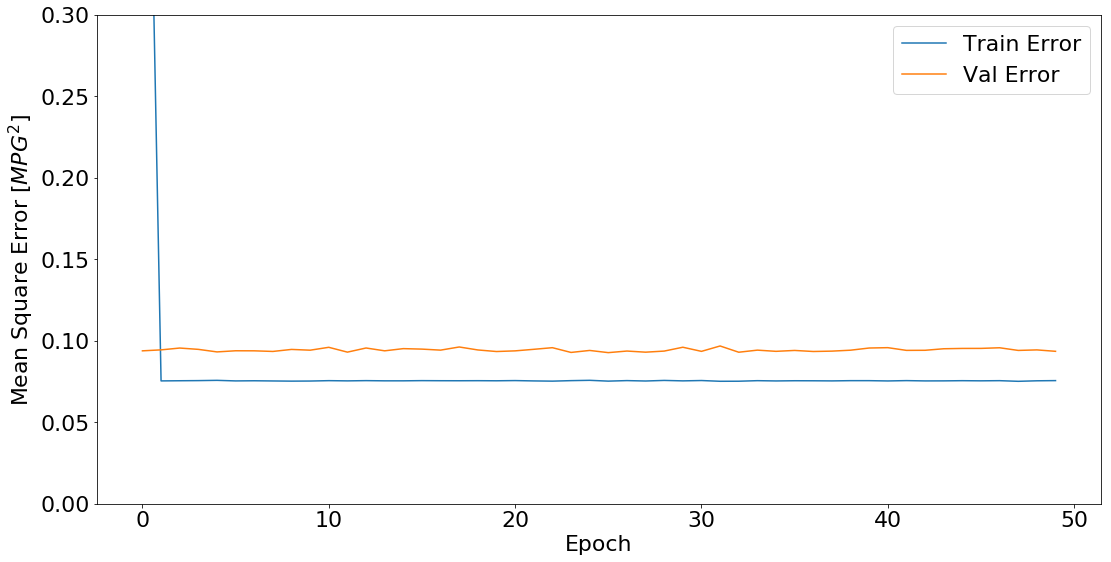

In [64]:
#plot MSE over epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim([0,0.3])

plot_history(history)

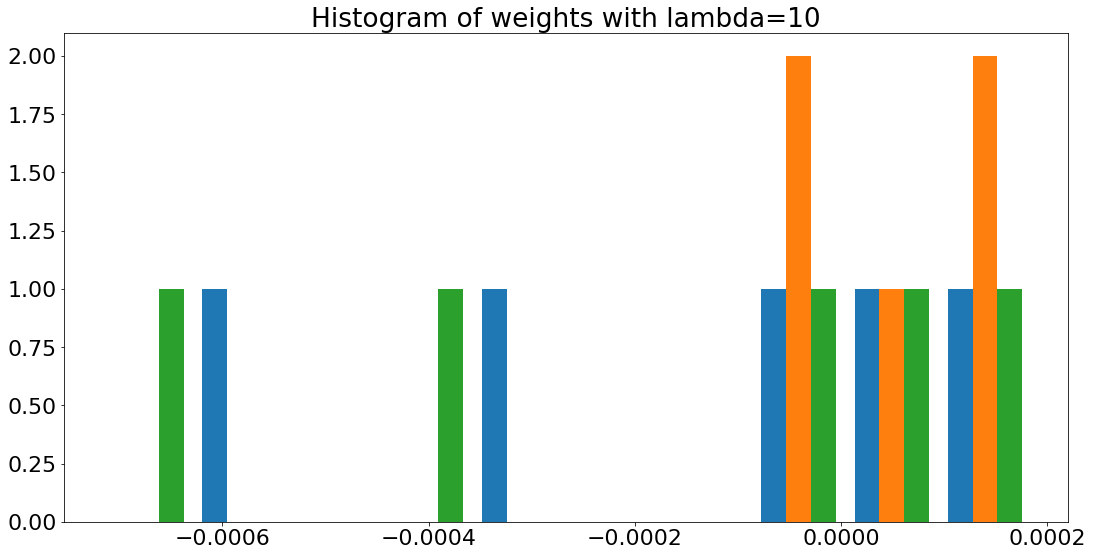

In [65]:
l1_weights = l1.get_weights()[0]
plt.hist(l1_weights)
plt.title("Histogram of weights with lambda=10")
plt.show()

The chosen regularization method is weight decay. With very strong regularization(e. g. lambda=10), the validation performance is constant. When we use a high value for weight decay, the value of the weights stay close to zero

In [84]:
#2 layer network
def build_model():
    layer1 = layers.Dense(8, activation=tf.sigmoid, input_shape=[5])
    model = keras.Sequential([
        #here the first number is the number of nodes in the first layer
        layer1, 
        #same for the second layer
        #layers.Dense(2, activation=tf.sigmoid),
        #output shape is 1
        layers.Dense(1)
    ])
    
    #can change learning rate here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)

    #mse is the chosen metric
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model, layer1

In [85]:
model, layer1 = build_model()

#comments a dot after every finished epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

#if patience number of epochs pass without showing improvement on the validation set, then 
#it will stop. If you want to test the network without it, remove it from callbacks attribute of the 
#next call
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  train_inputs, train_targets,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, #can set validation split here
  callbacks=[ PrintDot()])


..................................................

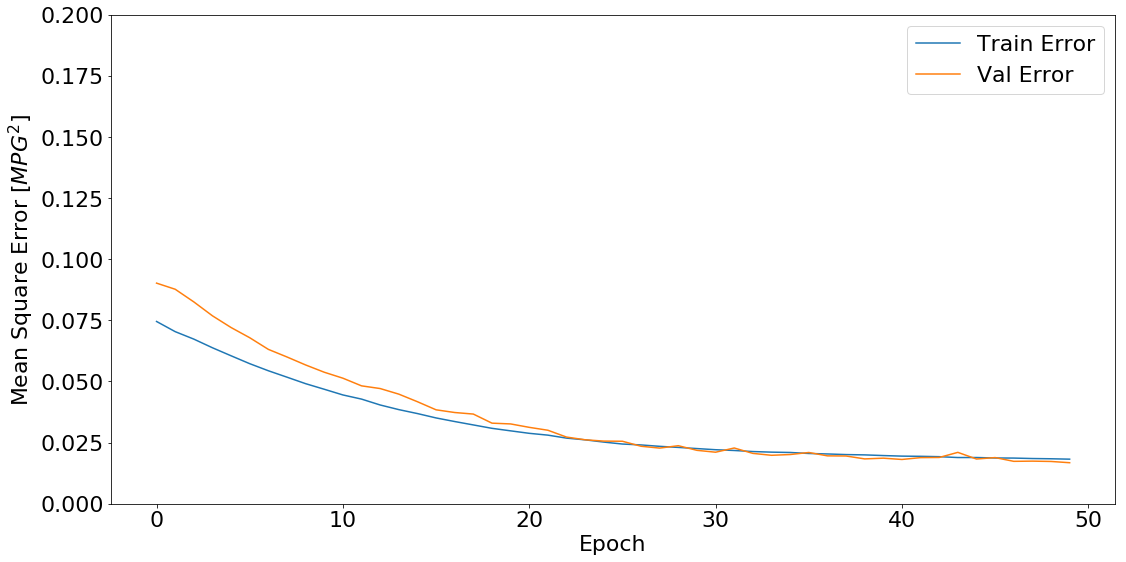

In [86]:
#plot MSE over epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim([0,0.2])

plot_history(history)

With 8 nodes, convergence is faster, but overfitting on the training data is bigger.

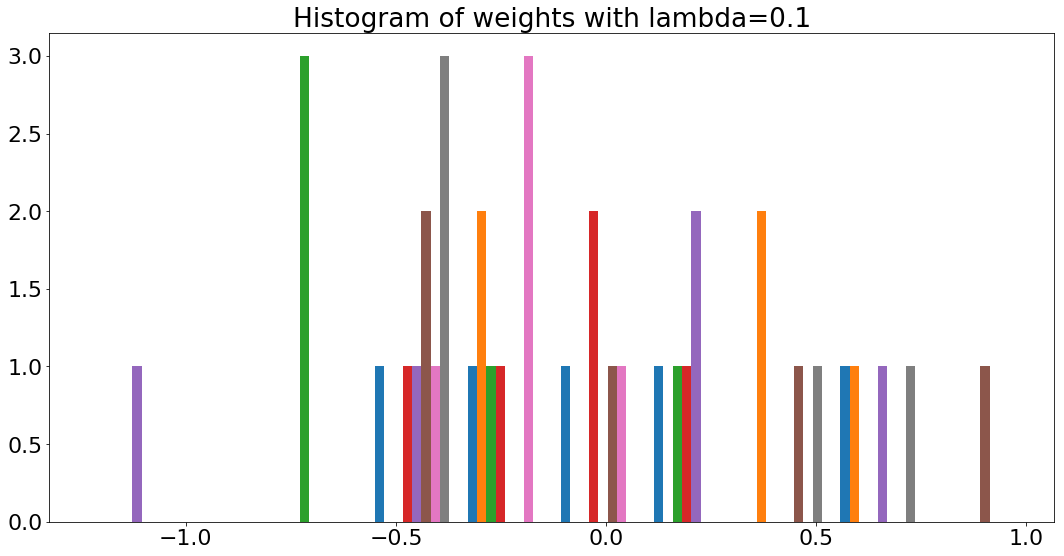

In [87]:
l1_weights = layer1.get_weights()[0]
plt.hist(l1_weights)
plt.title("Histogram of weights with lambda=0.1")
plt.show()

# Make predictions

In [88]:
loss, mse = model.evaluate(test_inputs, test_targets, verbose=0)
mse

0.021819554418325424

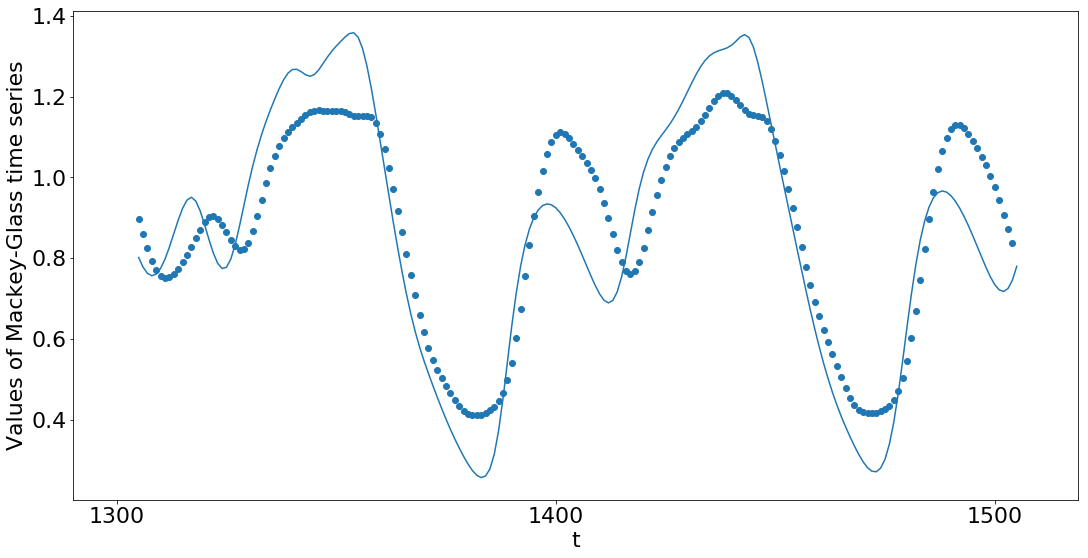

In [89]:
test_predictions = model.predict(test_inputs).flatten()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('Values of Mackey-Glass time series')

plt.xticks(np.arange(0, len(ts_vals), 100))
plt.scatter(range(1305, 1505), test_predictions)
plt.plot(range(1305, len(ts_vals)), ts_vals[1305:])
plt.show()